# Titanic_02 : 타이타닉 
---
- 타이타닉에 탑승한 사람들의 신상정보를 활용
- 승선한 사람들의 생존여부를 예측하는 모델을 생성
    - 여러 시각화 도구(matplotlib, seaborn, plotly), 데이터 분석 도구(pandas, numpy), 머신 러닝 도구(sklearn)을 사용


## 가설
---
1. Pclass :  좋은 객실을 사용한 승객이 더 많이 살아남았을 것이라는 가설 
2. Age : 젊은사람일수록 에너지가 있으니까 더 많이 살아 남았을거라는 가설 
3. Fare : 탑승료에 따른 생존률, 근데 이거는 pclass와 겹치거나 할것같음
4. sex : 여성이 더 많이 살아 남았을것이라는 가설 

In [1]:
# import
import numpy as np    # 넘파이
import pandas as pd   # 판다스 
import pandas as Series # 판다스 시리즈 임포트 

#  그래프 
import matplotlib.pyplot as plt   # 맷폴렛- 그래프
%matplotlib inline
import seaborn as sns      # 시본 - 그래프 
import missingno as msno   # missingno =>  missingno 패키지를 사용하면 누락데이터에 대한 시각화

plt.style.use('seaborn')
sns.set(font_scale=2.5)
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
# 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


# ?? 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go 
import plotly.tools as tls 


# ignore warnings
import warnings    # 워닝 방지
warnings.filterwarnings('ignore')



In [2]:
# ! pip install plotly

In [3]:
def search_path(dir_name = 'help'):
    import os
    
# dirname = '../../input'
    txt_err = '''
    - 여기 참고!
    ex) 만약 input => C:\input\train.csv에 위치한다면,
    1.  ->  '/'    -> 가장 최상의 디렉토리로 이동
        => / : root('C:')
    2.  ->  './'   -> 파일이 현재 디렉토리를 의미    
        => ./ : now_dir -> 내위치(=train.csv) -> train.csv
    3.  -> '../'   -> 상위 디렉토리로 이동
        => ../ : now_dir의 상단 폴더  -> input
    - 두단계 상위 디렉토리로 이동하려면 =>  '../../' 이렇게 사용
    '''
    if dir_name == 'help':
        print(txt_err)
    else:
        for dirname, _, filenames in os.walk(dir_name):
            
        #     print(dirname, _, filenames)
            for filename in filenames:
#                 print(filename)
                print(os.path.join(dirname, filename))
    
search_path('')

In [4]:
path = '../../input/%s.csv' 

df_train = pd.read_csv(path %'train')
df_test  = pd.read_csv(path % 'test')


In [5]:
# Titanic_01에서 진행한 내용 추가 

In [6]:
# FamilySize -> 학습, 테스트 모두 적용
# 자기자신을 포함해야하기 때문에 1을 더한다
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 

In [7]:
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()

In [8]:
df_train['Fare'] = df_train['Fare'].map(lambda i :np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i :np.log(i) if i > 0 else 0)

# 3.Feature engineering
--- 

- 본격적인 Feature engineering 시작 
- 가장 먼저 데이터셋에 존재하는 결측값을 채울것이다.     

- 의미없는 숫자로 채울 수는 없고, 결측데이터를 포함하는 feature의 statistics(통계)를 참고하거나, 다른 아이디어를 생각해내서 채울 수 있다.     
- 결측 데이터를 어떻게 채우는지에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분이다.

- Feature engineering은 실제 모델의 학습에 쓰려고 하는것 
- 학습, 테스트 모두 똑같이 적용해줘야한다!!!!!

## 결측치 채우기(Fill Null)
---

### 네임타이틀과 나이를 이용해 결측치 채우기 : Fill Null in Age using title

- 나이에는 177개의 결측치가 있다.
- 결측치를 채울 수 있는 여러가지 아이디어중 title + statistics를 사용 
- 영어에서는 Miss, Mrr, Mrs 같은 title이 존재
    - 각 승객의 이름에는 꼭 타이틀네임이 붙는다.
    - 이를 이용해서 진행 
    
- 판다스의 시리즈를 이용 
    - data -> string으로 바꾸어주는  str method가 존재 
    - 추가로 정규 표현식을 적용하게 해주는 extract method 존재 
    - 위 메소드로 쉽게 타이틀을 추출 가능 -> 타이틀을 Initial column에 저장
    

In [9]:
# 문자열 추가 
df_train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [10]:
# 이름 컬럼안에 있는 네임 타이틀을 가져온다.
# . 앞에 있는 글자를 가져온다 
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [11]:
df_train.Initial.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Sir           1
Capt          1
Don           1
Jonkheer      1
Lady          1
Countess      1
Mme           1
Ms            1
Name: Initial, dtype: int64

In [12]:
df_test.Initial.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Initial, dtype: int64

In [13]:
# pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count확인 
# train
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap = 'summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [14]:
# pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count확인 
# test
pd.crosstab(df_test['Initial'], df_test['Sex']).T.style.background_gradient(cmap = 'summer_r')

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [15]:
# 이름 표준화 
old_title = ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona']
new_title = ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr']

print('old_title = ',old_title,'\n','new_title =',new_title)

old_title =  ['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'] 
 new_title = ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr']


In [16]:
# 크로스테이블을 참고해서 남자, 여자가 쓰는 initial을 구분 
# replace를 사용해서 특정 데이터 값을 원하는 값으로 치환 

df_train['Initial'].replace(old_title,new_title,inplace=True)
df_test['Initial'].replace(old_title,new_title,inplace=True)

In [17]:
# 네이밍변경이 잘되었는지 확인 
df_train.Initial.value_counts()

Mr        529
Miss      186
Mrs       127
Master     40
Other       9
Name: Initial, dtype: int64

In [18]:
df_test.Initial.value_counts()

Mr        242
Miss       79
Mrs        72
Master     21
Other       4
Name: Initial, dtype: int64

![groupby정의](https://t1.daumcdn.net/cfile/tistory/9978503F5B8264490F)[참고](https://rfriend.tistory.com/383)

In [19]:
# 선택 컬럼의 중복 인덱스 기준으로 스플릿 
# 그리고 동일한 인덱스를 가진 데이터를 병합한다. 그런 다음 다시 재정렬한다. 
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는  Miss, Mr, Mrs 가 생존률이 높은 것을 확인가능!!

In [20]:
df_train.groupby('Initial').Survived.mean()

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

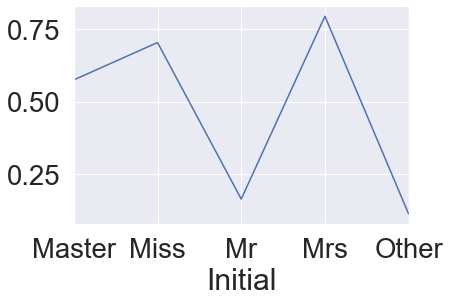

In [21]:
# 그래프로 그려보자 - plot 
# 좀 더 명확해야한다. -> 눈에 확띠는 !! 
df_train.groupby('Initial').Survived.mean().plot()

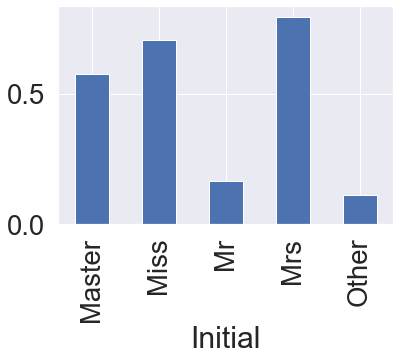

In [22]:
# 그래프로 표현 - bar : 
df_train.groupby('Initial').Survived.mean().plot.bar()

---

### 본격적인 결측값 채우기 

- 여러가지 방법이 존재 
    - statistics 를 활용 => 이거 사용 
    - null_data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워 넣는 방식
    
- statistics(통계) 는 train data 의 것을 의미
- test 를 unseen 으로 둔 상태로 유지 
- train 에서 얻은 statistics 를 기반으로 test 의 null_data 를 채워줘야 한다.

In [23]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


### Initial(머리글자) 기준
 
 - 나이의 평균을 이용해서 결측 값을 채울것 
 - 판다스의 데이터 프레임을 다룰때에는 불린 어레이를 이용해 인덱싱이 수월하다.
 - isnull()이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환
 - **loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙**

In [24]:
df_train.Age.isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: Age, Length: 891, dtype: bool

In [25]:
df_train.Initial == 'Mr'

0       True
1      False
2      False
3      False
4       True
       ...  
886    False
887    False
888    False
889     True
890     True
Name: Initial, Length: 891, dtype: bool

In [26]:
# isnull()이면서 동시에 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Mr'),'Age'] = 33

In [27]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Mr'),'Age']

Series([], Name: Age, dtype: float64)

[loc와 iloc의 차이](https://lemontia.tistory.com/886)

In [28]:
# np에서 중복값 추출 
# df_train.Initial.unique()
tmp = df_train.Initial.unique()
print(tmp, tmp[4],len(tmp))

['Mr' 'Mrs' 'Miss' 'Master' 'Other'] Other 5


In [29]:
df_train.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.798677
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [30]:
df_train.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.798677
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [31]:
test = df_train.groupby('Initial')['Age'].mean().unique()
test

# math 함수를 이용해 반올림 
# import math 
round(test[0])

5.0

In [32]:
df_train.Age.isnull().value_counts()

False    834
True      57
Name: Age, dtype: int64

In [33]:
# # 위와 같은 방법으로 다른 결측값도 진행 -> 각 initial 별로 -> 5회

# df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Mrs'),'Age'] = 36
# df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Master'),'Age'] = 5
# df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Miss'),'Age'] = 22
# df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Other'),'Age'] = 46

In [34]:
head_name = df_train.Initial.unique()

for i in range(len(head_name)):
    age_null = df_train.Age.isnull()
    add_avg= df_train.groupby('Initial')['Age'].mean().unique()
    print('-'*30)
    print('check_logs = ',head_name[i])
#     print(round(add_avg[i]))
    df_train.loc[(age_null)&(df_train.Initial == head_name[i] ),'Age'] = round(add_avg[i])
#     print(i)
    check_logs = df_train.Age.isnull().value_counts()
    print('\n',check_logs)
    print('-'*30)

------------------------------
check_logs =  Mr

 False    834
True      57
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Mrs

 False    851
True      40
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Miss

 False    887
True       4
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Master

 False    891
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Other

 False    891
Name: Age, dtype: int64
------------------------------


In [35]:
df_train.Age.isnull().value_counts()

False    891
Name: Age, dtype: int64

In [36]:
df_test.Age.isnull().value_counts()

False    332
True      86
Name: Age, dtype: int64

In [37]:
# # # test도 마찬가지로 진행 
# df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
# df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
# df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
# df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
# df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [38]:
test_head = df_test.Initial.unique()

for i in range(len(test_head)):
    age_null = df_test.Age.isnull()
    add_avg= df_test.groupby('Initial')['Age'].mean().unique()
    print('-'*30)
    print('check_logs = ',test_head[i])
#     print(round(add_avg[i]))
    df_test.loc[(age_null)&(df_test.Initial == test_head[i] ),'Age'] = round(add_avg[i])
#     print(i)
    check_logs = df_test.Age.isnull().value_counts()
    print('\n',check_logs) 
    print('-'*30)

------------------------------
check_logs =  Mr

 False    389
True      29
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Mrs

 False    399
True      19
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Miss

 False    414
True       4
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Master

 False    418
Name: Age, dtype: int64
------------------------------
------------------------------
check_logs =  Other

 False    418
Name: Age, dtype: int64
------------------------------


In [39]:
df_test.Age.isnull().value_counts()

False    418
Name: Age, dtype: int64

 - 간단한 방법으로 null값을 채움 
 - 자세히 공부하고자하면 [클릭](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

### 탑승항구 데이터 결측값 채우기: Fill Null in Embarked 
---
- 탑승항구 
    - 결측값이 2개, S에서 가장 많이 탑승 -> S의 값으로 널값을 채우겠다.
    - 데이터 프레임의 fillna를 이용하면 쉽게 채울 수 있다. 
        - inplace = Ture하면 df_train 에 fillna 를 실제로 적용

In [40]:
Embarked_null = sum(df_train.Embarked.isnull())
# print(Embarked_null)
print(f'Embarked has {Embarked_null}  Null values.')

Embarked has 2  Null values.


In [41]:
df_train['Embarked'].fillna('S', inplace= True)

In [42]:
Embarked_null = sum(df_test.Embarked.isnull())
# print(Embarked_null)
print(f'Embarked has {Embarked_null}  Null values.')

Embarked has 0  Null values.


### 나이 변경 : Change Age
- 연속적인 범주형(continuous to categorical)
---

- 나이는 연속적이 범주이다. 
- 이대로 사용은 가능하지만 그룹으로 구분하여 나이를 카테고리화가 가능하다.
- 이방법은 조금 위험성을 내포하고있다.
    - 잘못하면 정보 손실이 발생할 수 있다.
    - 지금은 최대한 경험하는 것이 목적이기 때문에 진행
    
- 방법은 여러가지가 있다. 
    - 데이터프레임의 인덱싱의 loc를 사용해서 직접해 줄 수 있다.
        - loc : 자주 사용하니 최대한 익숙해지는 것 목표
        - 나이 간격은 10살 간격으로 나누겠다.
    - apply를 사용해 함수를 넣어줄 수 도 있다.
        - 간단한 함수를 만들어 apply 메소드에 넣어주는 방법
        - loc 방법 보다 쉽다.

In [43]:
# 데이터 확인  -> 0.42 세에서 80세까지  
df_train.Age.sort_values()

803     0.42
755     0.67
469     0.75
644     0.75
831     0.83
       ...  
116    70.50
493    71.00
96     71.00
851    74.00
630    80.00
Name: Age, Length: 891, dtype: float64

In [44]:
# 70 세이상, 80세 이상 몇 개인지 확인 
# 트레인만 하는 이유는 트레인이랑 테스트랑 같아야 하기때문 
over_svn = len(df_train['Age'][df_train['Age']>= 70])
over_egh = len(df_train['Age'][df_train['Age']>= 80].shape)

print(f'over_svn = {over_svn}, over_egh = {over_egh}') 
# 70~79 , 80~89 카테고리를 만들기에는 데이터가 너무 적다 
# 그래서 70~79 와 80~89 합해서 70세 이상으로 정하겠다.
# -> 0.42 세에서 80세까지 분포 범위는 0 ~ 7까지 

over_svn = 7, over_egh = 1


In [45]:
# 컬럼은 생성한다. 
# 기본값 =  0 세팅 
df_train['Age_cat'] = 0
df_test['Age_cat'] = 0
# print(df_train['Age_cat'], len(df_train['Age_cat']) ) # 데이터 확인 

In [46]:
# 데이터 할당 - train
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age'])&(df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age'])&(df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age'])&(df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age'])&(df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age'])&(df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age'])&(df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[(70 <= df_train['Age']), 'Age_cat'] = 7
print(df_train['Age_cat'].unique(), len(df_train['Age_cat'].unique()))

[2 3 5 0 1 4 6 7] 8


In [47]:
# 데이터 할당 -test
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age'])&(df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age'])&(df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age'])&(df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age'])&(df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age'])&(df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age'])&(df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[(70 <= df_test['Age']), 'Age_cat'] = 7
print(df_test['Age_cat'].unique(), len(df_test['Age_cat'].unique()))

[3 4 6 2 1 0 5 7] 8


In [48]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [49]:
num = int(15)
test_li = list(range(num))

for i in test_li:
    print(category_age(i))
    print(i)
    print('='*5)

0
0
=====
0
1
=====
0
2
=====
0
3
=====
0
4
=====
0
5
=====
0
6
=====
0
7
=====
0
8
=====
0
9
=====
1
10
=====
1
11
=====
1
12
=====
1
13
=====
1
14
=====


In [50]:
# age의 각 인덱스가 함수에 할당되면서 연산 
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두가지 방법이 잘 적용됬다면, 둘다 같은 결과여야한다.
- 확인하기 위해서 시리즈간 블린으로 비교
    - all()을 이용
        - 모든 값이 True -> True 
        - 모든 값이 False -> False 
        
    
- 두 데이터가 동일 한것을 확인 
    - 중복되는 Age_cat 컬럼과 원래 컬럼을 제거 

In [51]:
# 비교 
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [52]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### 데이터 변경 네임헤드, 탑승항구, 성별 : Change Initial, Embarked and Sex 

- 문자열에서 숫자로 (string to numerical)

---

### Initial 
- 총 Mr, Mrs, Miss, Master, Other로  5개이다.

- 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 
    - 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 해야한다.  
        - 문자열 -> 수치화
        - map()을 이용하면 보다 간단하게 작업이 가능하다. 
        - 사전 순서대로 정리해서 mapping 작업을 진행 
        

In [53]:
Initial_cat= {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4}
df_train['Initial'] = df_train['Initial'].map(Initial_cat)
df_test['Initial'] = df_test['Initial'].map(Initial_cat)

In [54]:
df_train['Initial'], df_test['Initial']

(0      2
 1      3
 2      1
 3      3
 4      2
       ..
 886    4
 887    1
 888    1
 889    2
 890    2
 Name: Initial, Length: 891, dtype: int64, 0      2
 1      3
 2      2
 3      2
 4      3
       ..
 413    2
 414    2
 415    2
 416    2
 417    0
 Name: Initial, Length: 418, dtype: int64)

### Embarked 
- C, Q, S로 이루어져 있다. 
- map 을 이용해서 변경


- 특정 컬럼에 어떤 값이 존재하는지 확인 
    - 아래 내용 참조[-> 클릭](https://rfriend.tistory.com/267)
    - 간단하게 unique메소드()를 사용
    - value_counts()를 써서 count까지 확인 가능
    ![유일값, 유일값 카운드](https://t1.daumcdn.net/cfile/tistory/2665EA4A584EB4D515)

In [55]:
# Embarked가 S, C, Q 3개임을 확인 
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [56]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [57]:
Embarked_cat = {'C': 0, 'Q': 1, 'S': 2}
df_train['Embarked'] = df_train['Embarked'].map(Embarked_cat)
df_test['Embarked'] = df_test['Embarked'].map(Embarked_cat)

In [58]:
# 확인 
df_train['Embarked'],df_test['Embarked']

(0      2
 1      0
 2      2
 3      2
 4      2
       ..
 886    2
 887    2
 888    2
 889    0
 890    1
 Name: Embarked, Length: 891, dtype: int64, 0      1
 1      2
 2      1
 3      2
 4      2
       ..
 413    2
 414    0
 415    2
 416    2
 417    0
 Name: Embarked, Length: 418, dtype: int64)

### Null 여부 확인

- Embarked 컬럼만 가져온 것은 하나의 판다스 시리즈 객체다. 
- isnull() 메소드를 사용
    - Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있다.
    - 여기서 any() 를 사용 
        - True 가 **단 하나**라도 있을 시(Null이 한개라도 있을 시) True 를 반환
        
- 위에서 Null을 S로 다 바꿔주었다 -> 그래서 False

In [59]:
df_train['Embarked'].isnull().any()

False

### Sex 

- Female, male 
- map 을 이용 -> 카테고리화

In [60]:
Sex_cat = {'female': 0, 'male': 1}
df_train['Sex'] = df_train['Sex'].map(Sex_cat)
df_test['Sex'] = df_test['Sex'].map(Sex_cat)

### feature 간의 상관관계를 확인

- 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있다.
    - -1로 갈수록 음의 상관관계를 의미 
    -  1로 갈수록 양의 상관관계를 의미
    -  0은 상관관계가 없다는 것을 의미

**$$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$$**

-  여러 feature을 하나의 maxtrix 형태 만드는 것 => heatmap plot 
- dataframe 의 corr() 메소드와 seaborn 을 가지고 그릴 수 있다.

In [61]:
len(df_train.columns)

14

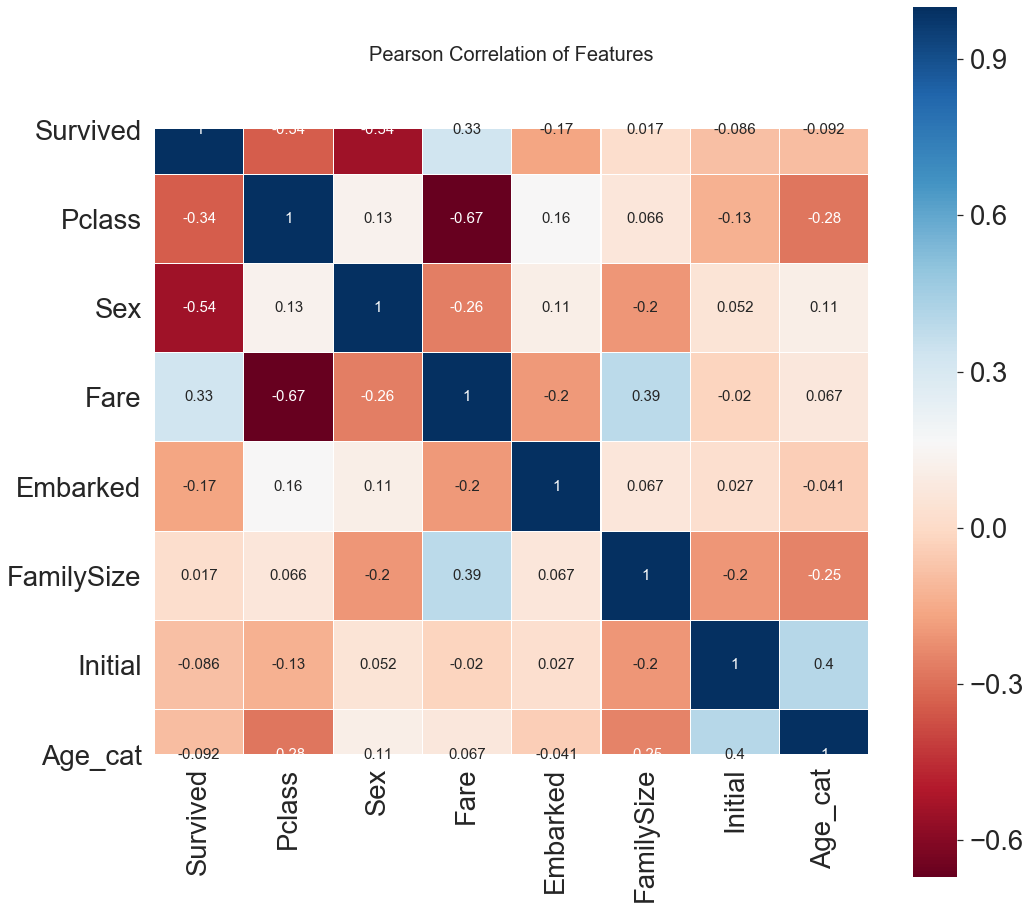

In [62]:
# 필요 특징만 꺼내서 진행 
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(16, 16))
plt.title('Pearson Correlation of Features', y=1.1, size=20)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 15})

# print(heatmap_data)
#  왜 삭제 하는 거지 ? 
del heatmap_data
# 왜 짤리는거지 ?

- EDA에서 확인 한바와 같이 Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 확인했다.
- 생각보다 fare 와 Embarked 도 상관관계가 있다는 것을 확인 되었다.
- 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것...
    - 이말은 모델을 학습시킬 때
        - 불필요한(redundant, superfluous) feature 가 없다는 것을 의미
        - 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나

- 모델을 학습전 data preprocessing (전처리)을 진행하겠다.

---

#  Initial and Embarked를 원-핫 인코딩 
    - One-hot encoding on Initial and Embarked

- 수치화시킨 카테고리 데이터를 넣어도 된다. 하지만  모델의 성능을 높이기 위해 one-hot encoding을 해줄 것이다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 이런식으로 매핑 해주는 것을 말한다. 
- one-hot encoding은 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 같이 (0,1)로 이루어진 5차원의 백터를 나타내는 것을 말한다. 

---

|  |Initial_Master|Initial_Miss|Initial_Mr|Initial_Mrs|Initial_Other|
|------|---|---|---|---|---|
|Master|1|0|0|0|0|
|Miss  |0|1|0|0|0|
|Mr    |0|0|1|0|0|
|Mrs   |0|0|0|1|0|
|Other |0|0|0|0|1|

---

- 위와 같은 작업을 직접 코딩 할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 가능하다.
- 총 5개의 카테고리 -> one-hot encoding 을 하고 나면 새로운 5개의 column 이 생긴다. 
- Initial 을 prefix로 두어서 구분이 쉽게 만들어 준다.

---

#### One-Hot-Encoding(원-핫-인코딩)
- dummy variable(가변수)을 만들어 factor형 변수를 0 또는 1 의 값을 가진 하나 이상의 새로운 특성으로 바꾼다.
- 따라서 특성당 0, 1의 값이 들어있기 때문에 binary classifier algorithm(이진 분류 알고리즘) 적용 가능하다.


---

### get_dummies() -> 문자열 특성만 인코딩되며 숫자 특성은 바뀌지 않는다.

- get_dummies()는 
    - 가변수(dummy var)를 만들 수 있다.
    - 적용 할 때 columns를 직접 입력 해야한다.
- prefix 옵션을 사용하면 가변수에 공통으로 접두사를 추가 가능하다.
- drop_first=True 옵션을 설정
     - 가변수의 첫번째 변수를 자동으로 삭제를 해주며, 가변수 함정(dummy trap)을 피할 수 있게 해준다.

- get_dummies()는 숫자 특성은 모두 연속형이라 생각해서 가변수를 만들지 않는다.
- 어떤 열이 연속형인지 범주형인지를 저장할 수 있는 scikit-learn의 OneHotEncoder를 사용 가능 
    - 추가로 DataFrame에 있는 숫자로 된 열을 문자열로 바꿀 수도 있음

[참조](https://woolulu.tistory.com/54)

In [65]:
df_train.Initial

0      2
1      3
2      1
3      3
4      2
      ..
886    4
887    1
888    1
889    2
890    2
Name: Initial, Length: 891, dtype: int64

In [66]:
# get_dummies()
# 가변수(dummy var)

test = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
test.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [67]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,2,3


In [68]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [69]:
# 오른쪽에 one-hot encoded columns 가 생성된것을 확인가능 
# Embarked 에도 적용 -> Initial과 동일한 기법으로 
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [70]:
# columns를 직접 입력 꼭 써줄것 
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 이렇게 원-핫 인코딩을 적용 
    - sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능하다.
    - 나중에 다시 해볼 것 -> 여기서는 get_dummies 로 충분히 가능
- 알고 넘어가자 !    
    - 가끔 category가 100개가 넘어가는 경우 존재 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있다. 그런 경우에는 다른 것을 사용한다. 

## 컬럼 정리 : Drop columns

- 요한 columns 만 남기고 다 지운다.

In [71]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Age_cat', 'Initial_0',
       'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

In [72]:
# 드랍할것 -> 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'
# train 과 test를 동일하게 제거 할 것
drop_it = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']

df_train.drop(drop_it, axis=1, inplace=True)
df_test.drop(drop_it, axis=1, inplace=True)

In [73]:
# 굉장히 깔끔 해진것을 확인할 수 있다.  
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [74]:
# train 의 Survived feature(target class)를 제외하면 train, test 둘 다 같은 columns 를 가진 걸 확인가능하다.
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 4. 훈련 된 모델을 사용하여 기계 학습 모델 구축 및 예측
: Building machine Learning model and prediction using the trained model

---
- [sklearn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning )을 사용해 본격적으로 머신러닝 모델 생성
- sklearn는 머신러닝의 모든것을 가지고 있음 
    - feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되었다.
    - 데이터 분석 + 머신러닝을 하고자하면 -> 필수 !!!!!

---

- 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(바이너리) binary classfication 문제!!
- train_set의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 만들 것
- 그리고 모델이 학습하지 않았던 test_set 을 input 으로 주어서 test_set 의 각 샘플(탑승객)의 생존 유무를 예측

In [75]:
# importing all the requested ML packages
from sklearn.ensemble import RandomForestClassifier  # 랜덤포레스트
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수
from sklearn import metrics                          # 모델의 평가를 위해서 사용

## 준비-데이터 세트를 기차, 유효, 테스트 세트로 분할
- Preparation - Split dataset into train, valid, test set

- 우선, 학습에 쓰일 데이터와, target label(Survived)를 분리 -> drop 을 사용해 간단히 진행 

In [79]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values # 정답만 추출 
X_test = df_test.values

- train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid_set(모이고사 같은 것)을 따로 만들어 모델 평가를 진행 
- train_test_split 을 사용하여 쉽게 train 셋을 분리

In [80]:
# 데이터 셋 분리 
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state = 2018)

- 랜덤포레스트
    - 랜덤포레스트는 결정트리기반 모델
    - 여러 결정 트리들을 앙상블한 모델

- 머신러닝 알고리즘에는 여러 파라미터들이 존재 
- 랜덤 포레스트 분류기
    - n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재 
         - 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라진다. 
         
- 파라미터를 튜닝하는 일
    - 시간, 경험, 알고리즘에 대한 이해 등이 필요하다. 
    - 결국 많이 써봐야 모델도 잘 세울 수 있다. 
        -> 캐글 추천 이유 
            - 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생긴데...ㅋㅋㅋ
            - 여기서는 본 default 세팅으로 진행
            - 모델 객체를 만들고, fit 메소드로 학습 -> valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 GET!
    

## 모델 생성 및 예측
- Model generation and prediction


In [81]:
# 모델 생성 
model = RandomForestClassifier()
# RandomForestClassifier.fit(X_tr, y_tr)
model.fit(X_tr, y_tr)
# 예측 
prediction = model.predict(X_vld)

In [84]:
print('총 {}명 중 {:.2f}정확도로 생존을 맞춤'.format(y_vld.shape[0], metrics.accuracy_score(prediction, y_vld) ))

총 268명 중 0.84정확도로 생존을 맞춤


In [82]:
# 튜닝없이
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld) ))

총 268명 중 84.33% 정확도로 생존을 맞춤


## 기능의 중요성: Fature importance

- Fature importance 가진다. 
    - 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있다. 
    - 즉, 10 = 3x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각
         - feature importance 는 3, 2, 1 =>  x1이 가장 큰 값(3)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있다.
    - 학습된 모델은 기본적으로 feature importances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있다.
    - pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있다.
    

In [89]:
from pandas import Series

In [85]:
model.feature_importances_

array([0.10045806, 0.03080437, 0.34247475, 0.08989018, 0.1368313 ,
       0.00474695, 0.05836822, 0.145809  , 0.04826619, 0.00654434,
       0.00780198, 0.01042003, 0.01758463])

In [87]:
feature_importance = model.feature_importances_

In [90]:
test = Series(feature_importance, index=df_test.columns)
test

Pclass        0.100458
Sex           0.030804
Fare          0.342475
FamilySize    0.089890
Age_cat       0.136831
Initial_0     0.004747
Initial_1     0.058368
Initial_2     0.145809
Initial_3     0.048266
Initial_4     0.006544
Embarked_0    0.007802
Embarked_1    0.010420
Embarked_2    0.017585
dtype: float64

In [91]:
feature_importance = model.feature_importances_
# pandas series 를 이용한 sorting
Series_feat_imp = Series(feature_importance, index=df_test.columns)

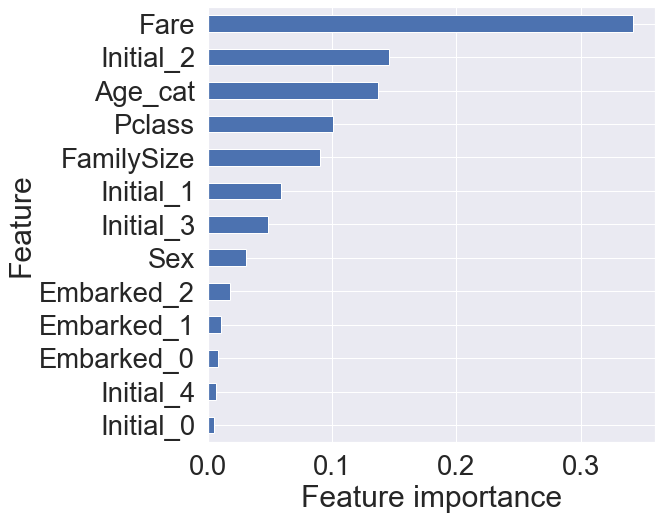

In [92]:
# 시각화
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- Fare 가 가장 큰 영향력
- Initial_2, Age_cat, Pclass가 차례로 중요도를 가진다.

- feature importance 는 지금 모델에서의 importance를 나타낸다.
- 만약 다른 모델을 사용 feature importance 가 다르게 나올 수 있다. 
- feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있다. 
    - 하지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적 검증이 필요하다.
    
- featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거도 가능하다. 


## 테스트 세트에 대한 예측 : Prediction on Test set
- 모델에서 학습하지 않았던 테스트셋을 모델에 줘 생존을 예측을 진행 
- 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비

In [96]:
submission = pd.read_csv('../../input/gender_submission.csv')
submission.head() # testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [98]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [99]:
submission.to_csv('./my_first_submission.csv', index=False)